## Overview

This notebook will show you how to create and query a table or DataFrame that you uploaded to DBFS. [DBFS](https://docs.databricks.com/user-guide/dbfs-databricks-file-system.html) is a Databricks File System that allows you to store data for querying inside of Databricks. This notebook assumes that you have a file already inside of DBFS that you would like to read from.

This notebook is written in **Python** so the default cell type is Python. However, you can use different languages by using the `%LANGUAGE` syntax. Python, Scala, SQL, and R are all supported.

In [ ]:
% Basic preprocessing and statistical analysis


In [ ]:
# File location and type
file_location = "/FileStore/tables/data_f.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df.show(5)

+--------------------+--------------------+--------------------+
|             overall|          reviewText|             summary|
+--------------------+--------------------+--------------------+
|                   5|The stained glass...|           Nice book|
|                   5|My 11 y.o. loved ...|                null|
|Dragons and Wizar...| that make it ""s...| or anything else...|
|Even the perfecti...| so it tends to b...|      Great pictures|
|                   5|The pictures are ...|The pictures are ...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col

df = df.filter(~col("overall").rlike('\D'))
df.show(5)

+-------+--------------------+--------------------+
|overall|          reviewText|             summary|
+-------+--------------------+--------------------+
|      5|The stained glass...|           Nice book|
|      5|My 11 y.o. loved ...|                null|
|      5|The pictures are ...|The pictures are ...|
|      5|I absolutely love...|       So beautiful!|
|      5|          I love it!|          Five Stars|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
df.count()

Out[116]: 1827525

In [ ]:
# Load the data
from pyspark.sql.functions import col

data = df.select(col("reviewText"), col("overall"))

In [ ]:
from pyspark.sql.functions import col, sum

# Count the number of null values in each column
null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

# Display the result
null_counts.show()


+----------+-------+
|reviewText|overall|
+----------+-------+
|         9|      0|
+----------+-------+



In [ ]:
# drop any rows with null values
data = data.na.drop()

In [ ]:
from pyspark.sql.functions import col, sum

# Count the number of null values in each column
null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

# Display the result
null_counts.show()


+----------+-------+
|reviewText|overall|
+----------+-------+
|         0|      0|
+----------+-------+



In [ ]:
data.count()

Out[121]: 1827516

In [ ]:
df.printSchema()
df.show(5)

root
 |-- overall: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)

+-------+--------------------+--------------------+
|overall|          reviewText|             summary|
+-------+--------------------+--------------------+
|      4|                cool|          Four Stars|
|      3|This is pretty mu...|This is pretty mu...|
|      4|its a cute little...|                Tiny|
|      5|Perfect for that ...|Entertains A 5 Ye...|
|      5|Great product. To...|             Awesome|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col
df = df.withColumn("overall", col("overall").cast("float"))


In [ ]:
df.printSchema()
df.show(5)

root
 |-- overall: float (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)

+-------+--------------------+--------------------+
|overall|          reviewText|             summary|
+-------+--------------------+--------------------+
|    4.0|                cool|          Four Stars|
|    3.0|This is pretty mu...|This is pretty mu...|
|    4.0|its a cute little...|                Tiny|
|    5.0|Perfect for that ...|Entertains A 5 Ye...|
|    5.0|Great product. To...|             Awesome|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.sql.types import IntegerType
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Step 1: Split the Data
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Step 2: Tokenize and Prepare Data
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
train_tokens = tokenizer.transform(train_df)
test_tokens = tokenizer.transform(test_df)

# Step 3: Convert Text to Sequences
sequence_length = 50

hashingTF = HashingTF(inputCol="words", outputCol="features", numFeatures=sequence_length)
train_seq = hashingTF.transform(train_tokens)
test_seq = hashingTF.transform(test_tokens)





train_seq = train_seq.withColumn("overall", train_seq["overall"].cast(IntegerType()))
test_seq = test_seq.withColumn("overall", test_seq["overall"].cast(IntegerType()))
train_seq = train_seq.filter(train_seq["overall"].isin([1, 2, 3, 4, 5]))
test_seq = test_seq.filter(test_seq["overall"].isin([1, 2, 3, 4, 5]))





train_seq = train_seq.na.drop()
test_seq = test_seq.na.drop()


# Step 4: Train the RNN Model
layers = [sequence_length, 30, 20, 10]  # Adjust the layer sizes as needed

# Create the RNN model
rnn = MultilayerPerceptronClassifier(layers=layers, seed=42, labelCol="overall")

# Train the RNN model
rnn_model = rnn.fit(train_seq)

# Step 5: Evaluate the Model
predictions = rnn_model.transform(test_seq)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="overall", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)


Accuracy: 0.7191860465116279


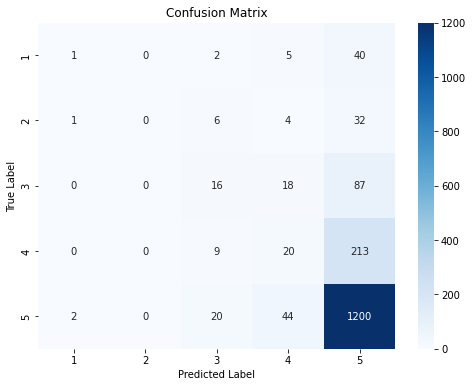

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Convert predictions to numpy array
predictions_np = np.array(predictions.select("overall", "prediction").collect())

# Extract actual labels and predicted labels
y_true = predictions_np[:, 0].astype(int)
y_pred = predictions_np[:, 1].astype(int)

# Get the class labels
class_labels = [1, 2, 3, 4, 5]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
train_seq.printSchema()

root
 |-- overall: float (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)

